In [21]:
import pandas as pd
import sqlite3
import numpy as np
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd

# my custom file
import Mapping_tools

In [22]:
# Connection to database:
con = sqlite3.connect('/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/blue_bikes.db')

### Run the view/table code once per session, it takes *forever* to run
Crash data includes all modes of transportation - filter to just bikes if needed

In [23]:
# Here are all the Views:
boston_crashes_2017 = pd.read_sql("SELECT * FROM boston_crash_reports_2017", con)
boston_crashes_2022 = pd.read_sql("SELECT * FROM boston_crash_reports_2022", con)
boston_fatalities_2017 = pd.read_sql("SELECT * FROM boston_fatality_report_2017", con)
boston_fatalities_2022 = pd.read_sql("SELECT * FROM boston_fatality_report_2022", con)
bike_5001 = pd.read_sql("SELECT * FROM bike_5001", con)
# Tables:
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2017", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM boston_crash_reports", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM boston_fatality_report", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)

### Testing mapping a dataframe to points

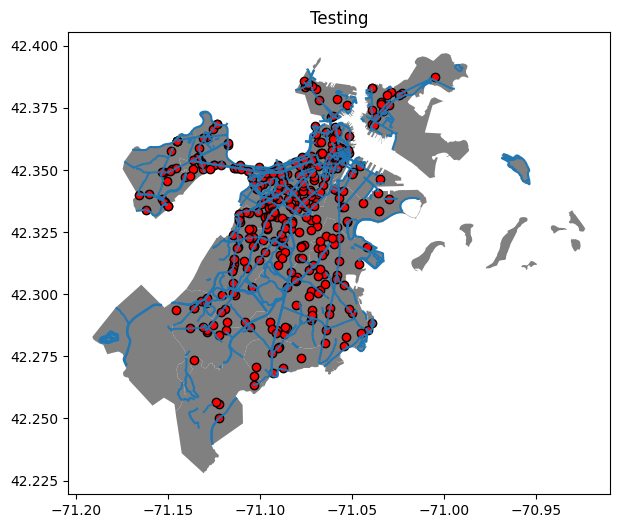

In [48]:
# Filter crash data to just bikes
bike_crashes_2017 = boston_crashes_2017[boston_crashes_2017["mode_type"] == 'bike'] 

# Mapping a dataframe with lat/long data to a point file
points = [Point(xy) for xy in zip(bike_crashes_2017['long'], bike_crashes_2017['lat'])]
# Convert that point layer into a geodataframe object
crashes_2017 = gpd.GeoDataFrame(bike_crashes_2017, crs="EPSG:4326", geometry=points)


# Read in bike lanes file
bike_lanes = gpd.read_file('/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/bos-bike-paths-2022.geojson')

# Add shapefile of Boston Neighborhoods https://data.boston.gov/dataset/boston-neighborhoods
boston_neighborhoods = gpd.read_file(
    "/Users/zacharyarmand/Documents/DS5110-blue-bikes/Data/Boston_Neighborhoods/Boston_Neighborhoods.shp",
    type='Polygon')
boston_neighborhoods = boston_neighborhoods.to_crs('EPSG:4326')


# create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Neighborhood background map
#nhoods.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot

# Plot background images
bike_lanes.plot(ax=ax)
boston_neighborhoods.plot(ax=ax, color='grey')

# Plot data
crashes_2017.plot(edgecolor='#000000', legend=True, categorical=False, ax=ax, color='r')
plt.title("Testing")
plt.show()

## Ignore this - Zack working on creating a network of one bike

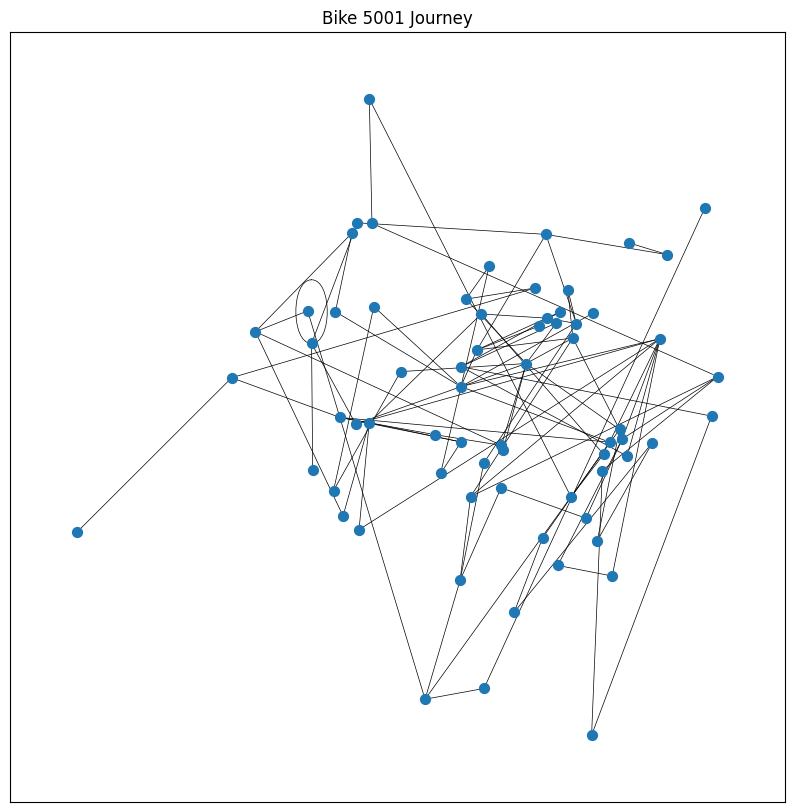

In [28]:


bike5001_network = pd.read_sql("SELECT * FROM bike_5001 ORDER BY starttime LIMIT 100", con)


'''
G = nx.from_pandas_edgelist(question8, 'start_station_name', 'end_station_name', create_using=nx.Graph())  # undirected, unweighted graph
# Create figure
plt.figure(figsize=(15,15), dpi=100)
plt.title("Bike 5001 Journey.")
nx.draw_networkx(G, labels="", node_size=5) #node_color=node_colors, labels=nx_labels, node_size=50, font_size=15)
plt.show()

'''

G = nx.Graph()

#for row in bike5001_network.itertuples(index=False):
for index, row in bike5001_network.iterrows():
  ###G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  # Add the nodes to the graph
  G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  G.add_node(row.end_station_name, pos=(row.end_station_longitude, row.end_station_latitude))

  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


# Extract the node positions from the graph
node_positions = {node: node_data['pos'] for node, node_data in G.nodes(data=True)}

# Draw the graph
plt.figure(figsize=(10,10), dpi=100)
plt.title("Bike 5001 Journey")


# Change node colors to differentiate genes and diseases
edge_colors = range(100)

nx.draw_networkx(G, pos=node_positions, with_labels=False, arrows=True, node_size=50,
                 width=0.5, font_size=8)#,
                 #edge_cmap = plt.cm.Blues,
                 #edge_color = edge_colors)


plt.show()





#nx.draw(G, nx.get_node_attributes(G, 'pos'),
#        with_labels=False,
#        node_size=20,
#        node_color=range(274),
#        cmap=plt.cm.Blues)


#G2 = nx.from_pandas_edgelist(bike5001_network, 'start_station_name', 'end_station_name', create_using=nx.Graph())
#nx.draw_networkx(G2, labels="", node_size=5) #node_color=node_colors, labels=nx_labels, node_size=50, font_size=15)




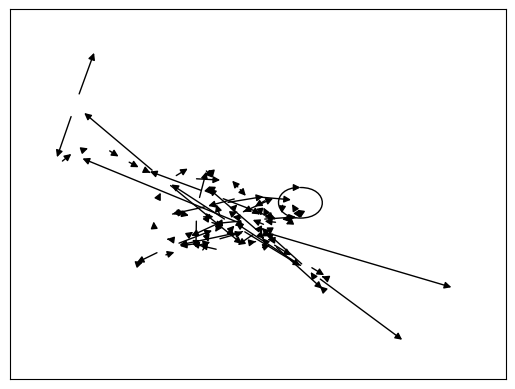

In [29]:
G = nx.DiGraph()

#G.add_edges_from([(1, 2), (1, 3), (2, 3)])

for index, row in bike5001_network.iterrows():
  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))